In [1]:
import warnings

warnings.filterwarnings("ignore")

import jax
from jax import numpy as jnp, random as jr

from matplotlib import pyplot as plt

from plot import make_plotter_2d
from inference import make_gradfun, sgd
from gmm import init_pgm_param, run_inference
from network import init_gresnet, make_loglike, gaussian_info, gaussian_mean

In [2]:
def make_pinwheel_data(key, radial_std, tangential_std, num_classes, num_per_class, rate):
    rads = jnp.linspace(0, 2 * jnp.pi, num_classes, endpoint=False)

    num_samples = num_classes * num_per_class

    subkey, key = jr.split(key)
    features = jr.normal(subkey, (num_samples, 2)) * jnp.array([radial_std, tangential_std])
    features = features.at[:, 0].add(1.0)

    labels = jnp.repeat(jnp.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * jnp.exp(features[:, 0])

    rotations = jnp.stack([jnp.cos(angles), -jnp.sin(angles), jnp.sin(angles), jnp.cos(angles)])
    rotations = rotations.T.reshape(-1, 2, 2)

    features = jnp.einsum("ti,tij->tj", features, rotations)

    subkey, key = jr.split(key)
    permuted_features = 10 * jr.permutation(subkey, features)

    return permuted_features

In [3]:
key = jr.PRNGKey(0)

num_clusters = 5 
samples_per_cluster = 100 

data_key, key = jr.split(key)
data = make_pinwheel_data(data_key, 0.3, 0.05, num_clusters, samples_per_cluster, 0.25)

99: 9.548035621643066


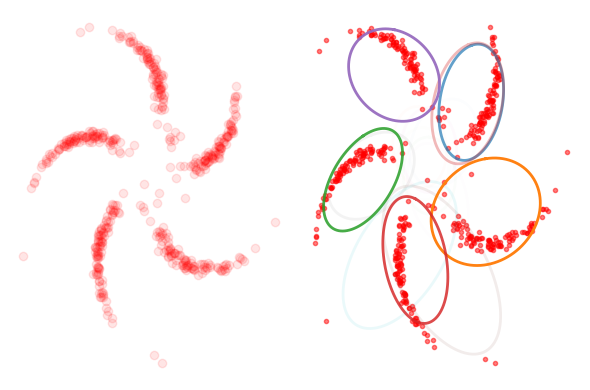

199: 6.79965353012085


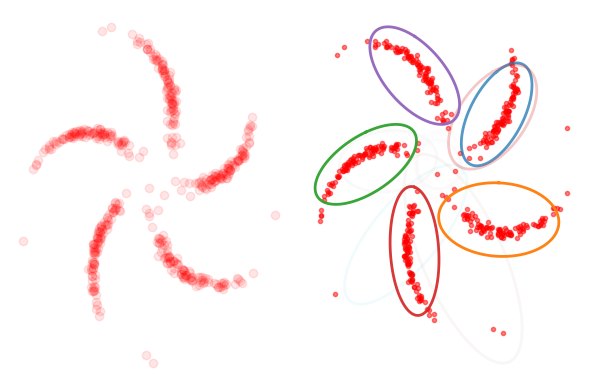

299: 6.724037170410156


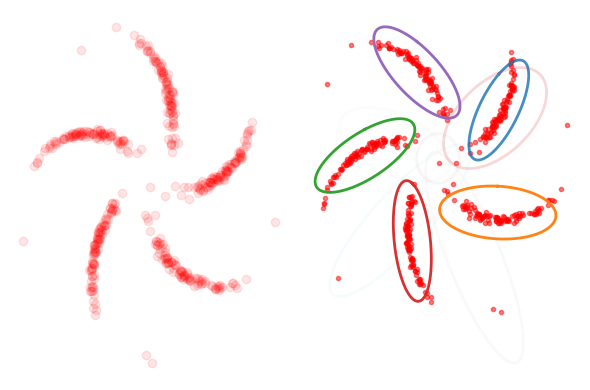

399: 6.701984882354736


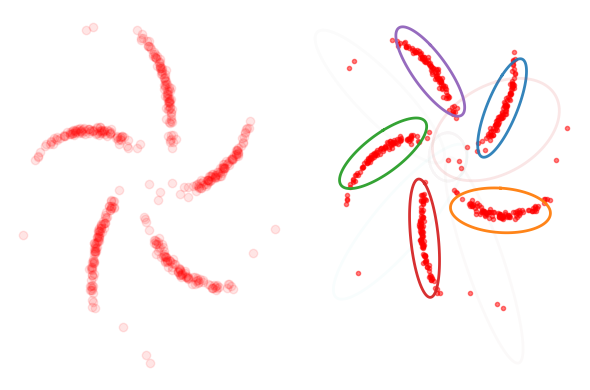

499: 6.707624435424805


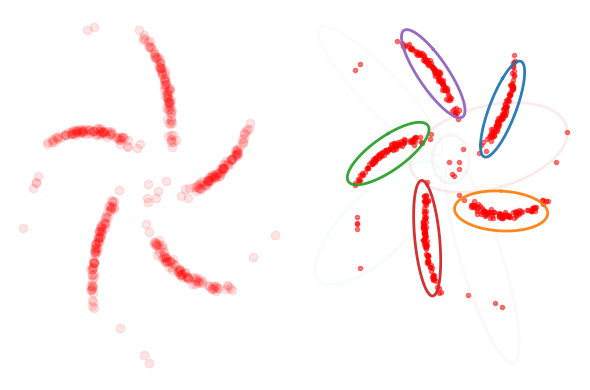

599: 6.6164326667785645


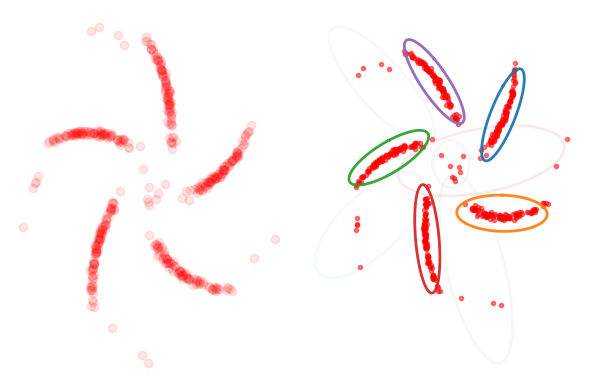

699: 6.610454559326172


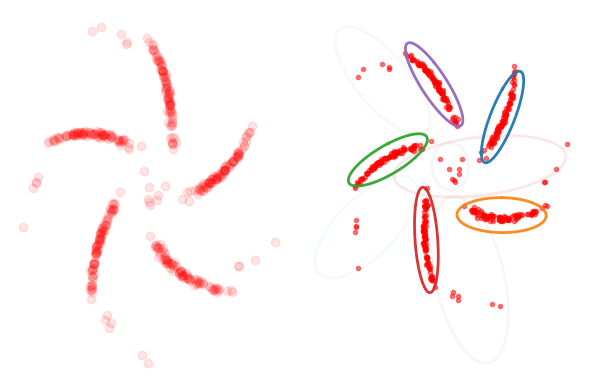

In [ ]:
K, N, D = 15, 2, 2

prior_key, key = jr.split(key)
pgm_prior_params = init_pgm_param(prior_key, K, N, alpha=0.05 / K, niw_conc=0.5)

encoder_key, key = jr.split(key)
encoder, encoder_params = init_gresnet(encoder_key, D, [(40, jnp.tanh), (40, jnp.tanh), (2 * N, gaussian_info)])

decoder_key, key = jr.split(key)
decoder, decoder_params = init_gresnet(decoder_key, N, [(40, jnp.tanh), (40, jnp.tanh), (2 * D, gaussian_mean)])
loglike = make_loglike(decoder)

pgm_key, key = jr.split(key)
pgm_params = init_pgm_param(pgm_key, K, N, alpha=1.0, niw_conc=1.0, random_scale=3.0)
params = pgm_params, decoder_params, encoder_params

plot_key, key = jr.split(key)
plot = make_plotter_2d(key, encoder, decoder, data, num_clusters, params, plot_every=999)

grad_key, key = jr.split(key)
gradfun = make_gradfun(grad_key, run_inference, encoder, loglike, pgm_prior_params, data, 50, 1, 1e4, plot)

sgd_key, key = jr.split(key)
params = sgd(sgd_key, gradfun, params, 1000, 1e-3)